**In this task I tried to create a hybrid model for stock performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines. (Used Stack LSTM)**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
nltk.download('vader_lexicon')

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


**Importing the Numerical dataset and performing Exploratory Analysis**

In [2]:
stock_price = pd.read_csv('APPL_stocks.csv')
stock_headlines = pd.read_csv('APPL_news.csv')

In [3]:
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2024-03-28,171.750000,172.229996,170.509995,171.479996,171.479996,65672700
1,2024-04-01,171.190002,171.250000,169.479996,170.029999,170.029999,46240500
2,2024-04-02,169.080002,169.339996,168.229996,168.839996,168.839996,49329500
3,2024-04-03,168.789993,170.679993,168.580002,169.649994,169.649994,47691700
4,2024-04-04,170.289993,171.919998,168.820007,168.820007,168.820007,53704400


In [4]:
stock_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       23 non-null     object 
 1   Open       23 non-null     float64
 2   High       23 non-null     float64
 3   Low        23 non-null     float64
 4   Close      23 non-null     float64
 5   Adj Close  23 non-null     float64
 6   Volume     23 non-null     int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 1.4+ KB


In [5]:
stock_headlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   publish_date   501 non-null    object
 1   headline_text  501 non-null    object
dtypes: object(2)
memory usage: 8.0+ KB


**Feature Engineering**

In [6]:
# checking for null values in both the datasets
stock_price.isna().any(), stock_headlines.isna().any()

(Date         False
 Open         False
 High         False
 Low          False
 Close        False
 Adj Close    False
 Volume       False
 dtype: bool,
 publish_date     False
 headline_text    False
 dtype: bool)

Stock Price Data

In [7]:
# dropping duplicates
stock_price = stock_price.drop_duplicates()

# coverting the datatype of column 'Date' from type object to type 'datetime'
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()

# filtering the important columns required
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as the index column
stock_price.set_index('Date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2024-03-28,171.479996,171.750000,172.229996,170.509995,65672700
2024-04-01,170.029999,171.190002,171.250000,169.479996,46240500
2024-04-02,168.839996,169.080002,169.339996,168.229996,49329500
2024-04-03,169.649994,168.789993,170.679993,168.580002,47691700
2024-04-04,168.820007,170.289993,171.919998,168.820007,53704400
2024-04-05,169.580002,169.589996,170.389999,168.949997,42055200
2024-04-08,168.449997,169.029999,169.199997,168.240005,37425500
2024-04-09,169.669998,168.699997,170.080002,168.350006,42451200
2024-04-10,167.779999,168.800003,169.089996,167.110001,49709300


Stock News Headlines Data

In [8]:
# dropping duplicates
stock_headlines = stock_headlines.drop_duplicates()

# coverting the datatype of column 'Date' from type string to type 'datetime'
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date'], format='%d/%m/%Y')

# filtering the important columns required
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])

# grouping the news headlines according to 'Date'
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting column 'Date' as the index column
stock_headlines.set_index('publish_date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2024-03-28,warren buffett is raking in %244.36 billion in...
2024-03-29,will warren buffett sell more apple stock beca...
2024-03-30,will artificial intelligence ai allow nvidia t...
2024-03-31,guru fundamental report for aapl warren buffet...
2024-04-01,the best case scenarios for the magnificent 7 ...
2024-04-02,leaked ios 18 reveals visionos inspired redesi...
2024-04-03,up 19 ytd how high can amazon stock go in 2024...
2024-04-04,nike stock 2025 forecast%3A is nke a good long...
2024-04-05,the apple antitrust fallout%3A 3 stocks poised...


Combined Stock Data

In [9]:
# concatenating the datasets stock_price and stock_headlines
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

# dropping the null values if any
stock_data.dropna(axis=0, inplace=True)

# displaying the combined stock_data
stock_data

,Close,Open,High,Low,Volume,headline_text
2024-03-28,171.479996,171.750000,172.229996,170.509995,65672700.0,warren buffett is raking in %244.36 billion in...
2024-04-01,170.029999,171.190002,171.250000,169.479996,46240500.0,the best case scenarios for the magnificent 7 ...
2024-04-02,168.839996,169.080002,169.339996,168.229996,49329500.0,leaked ios 18 reveals visionos inspired redesi...
2024-04-03,169.649994,168.789993,170.679993,168.580002,47691700.0,up 19 ytd how high can amazon stock go in 2024...
2024-04-04,168.820007,170.289993,171.919998,168.820007,53704400.0,nike stock 2025 forecast%3A is nke a good long...
2024-04-05,169.580002,169.589996,170.389999,168.949997,42055200.0,the apple antitrust fallout%3A 3 stocks poised...
2024-04-08,168.449997,169.029999,169.199997,168.240005,37425500.0,the bull run in nvidia stock has only just beg...
2024-04-09,169.669998,168.699997,170.080002,168.350006,42451200.0,meet the only magnificent seven stock billiona...
2024-04-10,167.779999,168.800003,169.089996,167.110001,49709300.0,guru fundamental report for aapl warren buffet...
2024-04-11,175.039993,168.339996,175.460007,168.160004,91070300.0,3 giant tech stocks to buy in april and hold f...


Calculating Sentiment Scores

In [10]:
# adding empty sentiment columns to stock_data for later calculation
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2024-03-28,171.479996,171.750000,172.229996,170.509995,65672700.0,warren buffett is raking in %244.36 billion in...,,,,
2024-04-01,170.029999,171.190002,171.250000,169.479996,46240500.0,the best case scenarios for the magnificent 7 ...,,,,
2024-04-02,168.839996,169.080002,169.339996,168.229996,49329500.0,leaked ios 18 reveals visionos inspired redesi...,,,,
2024-04-03,169.649994,168.789993,170.679993,168.580002,47691700.0,up 19 ytd how high can amazon stock go in 2024...,,,,
2024-04-04,168.820007,170.289993,171.919998,168.820007,53704400.0,nike stock 2025 forecast%3A is nke a good long...,,,,


In [11]:
# importing requires libraries to analyze the sentiments
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

# instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# calculating sentiment scores
stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])

# displaying the stock data
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2024-03-28,171.479996,171.750000,172.229996,170.509995,65672700.0,warren buffett is raking in %244.36 billion in...,0.9493,0.018,0.879,0.103
2024-04-01,170.029999,171.190002,171.250000,169.479996,46240500.0,the best case scenarios for the magnificent 7 ...,0.9929,0.000,0.692,0.308
2024-04-02,168.839996,169.080002,169.339996,168.229996,49329500.0,leaked ios 18 reveals visionos inspired redesi...,0.9442,0.012,0.862,0.126
2024-04-03,169.649994,168.789993,170.679993,168.580002,47691700.0,up 19 ytd how high can amazon stock go in 2024...,0.9412,0.030,0.833,0.137
2024-04-04,168.820007,170.289993,171.919998,168.820007,53704400.0,nike stock 2025 forecast%3A is nke a good long...,0.9830,0.022,0.830,0.148


**Finalising Stock Data and save to a new dataframe**

In [12]:
# dropping the 'headline_text' which is unwanted now
stock_data.drop(['headline_text'], inplace=True, axis=1)

# rearranging the columns of the whole stock_data
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# displaying the final stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2024-03-28,171.479996,0.9493,0.018,0.879,0.103,171.750000,172.229996,170.509995,65672700.0
2024-04-01,170.029999,0.9929,0.000,0.692,0.308,171.190002,171.250000,169.479996,46240500.0
2024-04-02,168.839996,0.9442,0.012,0.862,0.126,169.080002,169.339996,168.229996,49329500.0
2024-04-03,169.649994,0.9412,0.030,0.833,0.137,168.789993,170.679993,168.580002,47691700.0
2024-04-04,168.820007,0.9830,0.022,0.830,0.148,170.289993,171.919998,168.820007,53704400.0


In [13]:
stock_data.to_csv('datafinal.csv')

**Reading Stock Data**

In [14]:
# re-reading the stock_data into pandas dataframe
stock_data = pd.read_csv('datafinal.csv', index_col = False)

# renaming the column
stock_data.rename(columns={'Unnamed: 0':'Date'}, inplace = True)

# setting the column 'Date' as the index column
stock_data.set_index('Date', inplace=True)

# displaying the stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2024-03-28,171.479996,0.9493,0.018,0.879,0.103,171.750000,172.229996,170.509995,65672700.0
2024-04-01,170.029999,0.9929,0.000,0.692,0.308,171.190002,171.250000,169.479996,46240500.0
2024-04-02,168.839996,0.9442,0.012,0.862,0.126,169.080002,169.339996,168.229996,49329500.0
2024-04-03,169.649994,0.9412,0.030,0.833,0.137,168.789993,170.679993,168.580002,47691700.0
2024-04-04,168.820007,0.9830,0.022,0.830,0.148,170.289993,171.919998,168.820007,53704400.0


**Feature Engineering of Stock Data**

In [15]:
stock_data.shape

(22, 9)

In [16]:
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [17]:
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,2.200000e+01
mean,169.676817,0.866123,0.029773,0.835091,0.135000,169.762272,171.365908,168.555456,5.731052e+07
std,2.801202,0.204231,0.023189,0.057690,0.057277,2.735010,3.269524,2.540590,1.665887e+07
min,165.000000,0.101000,0.000000,0.692000,0.062000,165.350006,166.399994,164.080002,3.742550e+07
25%,168.112499,0.847125,0.010500,0.825500,0.105000,168.429996,169.224998,167.332500,4.660330e+07
50%,169.340004,0.945250,0.026000,0.851500,0.129000,169.334999,170.664993,168.310005,4.962355e+07
75%,170.255001,0.968700,0.044000,0.870250,0.150250,171.610001,173.377495,169.404995,6.731278e+07
max,176.550003,0.992900,0.079000,0.930000,0.308000,175.360001,178.360001,174.210007,1.015933e+08


In [18]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 2024-03-28 to 2024-04-30
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     22 non-null     float64
 1   compound  22 non-null     float64
 2   negative  22 non-null     float64
 3   neutral   22 non-null     float64
 4   positive  22 non-null     float64
 5   Open      22 non-null     float64
 6   High      22 non-null     float64
 7   Low       22 non-null     float64
 8   Volume    22 non-null     float64
dtypes: float64(9)
memory usage: 1.7+ KB


**EDA of Stock Data**

Text(0, 0.5, 'Close Price ($)')

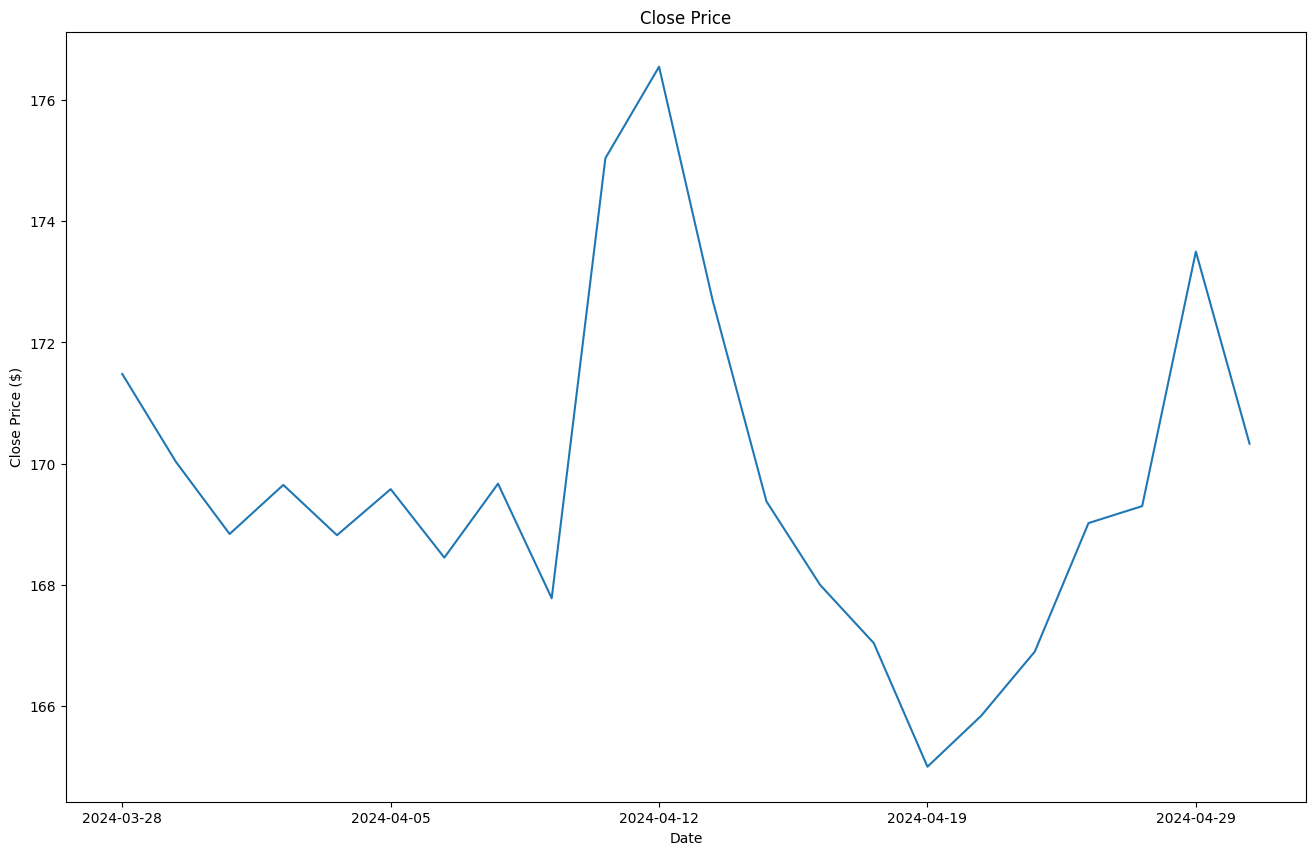

In [19]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting close price
stock_data['Close'].plot()

# setting plot title, x and y labels
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price ($)')

In [20]:
# calculating 7 day rolling mean
stock_data.rolling(7).mean().head(20) 

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2024-03-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-08,169.549999,0.956171,0.023000,0.800714,0.176286,169.959998,170.715711,168.972857,4.887421e+07
2024-04-09,169.291428,0.958814,0.021714,0.797000,0.181286,169.524283,170.408569,168.664287,4.555686e+07
2024-04-10,168.969999,0.955400,0.029429,0.811714,0.158857,169.182855,170.099997,168.325716,4.605240e+07


**Data Preparation for Modelling**

In [21]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 16
Number of records in Test Data: 6


In [22]:
# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
close_price = stock_data.iloc[start:total_data,0] #close
compound = stock_data.iloc[start:total_data,1] #compound
negative = stock_data.iloc[start:total_data,2] #neg
neutral = stock_data.iloc[start:total_data,3] #neu
positive = stock_data.iloc[start:total_data,4] #pos
open_price = stock_data.iloc[start:total_data,5] #open
high = stock_data.iloc[start:total_data,6] #high
low = stock_data.iloc[start:total_data,7] #low
volume = stock_data.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price  

Close Price:


Date
2024-04-01    170.029999
2024-04-02    168.839996
2024-04-03    169.649994
2024-04-04    168.820007
2024-04-05    169.580002
2024-04-08    168.449997
2024-04-09    169.669998
2024-04-10    167.779999
2024-04-11    175.039993
2024-04-12    176.550003
2024-04-15    172.690002
2024-04-16    169.380005
2024-04-17    168.000000
2024-04-18    167.039993
2024-04-19    165.000000
2024-04-22    165.839996
2024-04-23    166.899994
2024-04-24    169.020004
2024-04-26    169.300003
2024-04-29    173.500000
2024-04-30    170.330002
Name: Close, dtype: float64

In [23]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,,
2024-04-01,170.029999,168.839996,0.9929,0.9442,46240500.0,171.190002,171.250000,169.479996
2024-04-02,168.839996,169.649994,0.9442,0.9412,49329500.0,169.080002,169.339996,168.229996
2024-04-03,169.649994,168.820007,0.9412,0.9830,47691700.0,168.789993,170.679993,168.580002
2024-04-04,168.820007,169.580002,0.9830,0.9274,53704400.0,170.289993,171.919998,168.820007
2024-04-05,169.580002,168.449997,0.9274,0.9552,42055200.0,169.589996,170.389999,168.949997
2024-04-08,168.449997,169.669998,0.9552,0.9678,37425500.0,169.029999,169.199997,168.240005
2024-04-09,169.669998,167.779999,0.9678,0.9690,42451200.0,168.699997,170.080002,168.350006
2024-04-10,167.779999,175.039993,0.9690,0.7003,49709300.0,168.800003,169.089996,167.110001
2024-04-11,175.039993,176.550003,0.7003,0.1010,91070300.0,168.339996,175.460007,168.160004


**Setting the Target Variable and the Feature Dataset**

In [24]:
# setting the target variable as the shifted close_price
y = data['close_price_shifted']
y

Date
2024-04-01    168.839996
2024-04-02    169.649994
2024-04-03    168.820007
2024-04-04    169.580002
2024-04-05    168.449997
2024-04-08    169.669998
2024-04-09    167.779999
2024-04-10    175.039993
2024-04-11    176.550003
2024-04-12    172.690002
2024-04-15    169.380005
2024-04-16    168.000000
2024-04-17    167.039993
2024-04-18    165.000000
2024-04-19    165.839996
2024-04-22    166.899994
2024-04-23    169.020004
2024-04-24    169.300003
2024-04-26    173.500000
2024-04-29    170.330002
Name: close_price_shifted, dtype: float64

In [25]:
# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,
2024-04-01,170.029999,0.9929,0.9442,46240500.0,171.190002,171.250000,169.479996
2024-04-02,168.839996,0.9442,0.9412,49329500.0,169.080002,169.339996,168.229996
2024-04-03,169.649994,0.9412,0.9830,47691700.0,168.789993,170.679993,168.580002
2024-04-04,168.820007,0.9830,0.9274,53704400.0,170.289993,171.919998,168.820007
2024-04-05,169.580002,0.9274,0.9552,42055200.0,169.589996,170.389999,168.949997
2024-04-08,168.449997,0.9552,0.9678,37425500.0,169.029999,169.199997,168.240005
2024-04-09,169.669998,0.9678,0.9690,42451200.0,168.699997,170.080002,168.350006
2024-04-10,167.779999,0.9690,0.7003,49709300.0,168.800003,169.089996,167.110001
2024-04-11,175.039993,0.7003,0.1010,91070300.0,168.339996,175.460007,168.160004


Scaling the Target Variable and the Feature Dataset

In [26]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[-0.12900477,  1.        ,  0.90102581, -0.72525161,  0.16683308,
         -0.18896265,  0.06613846],
        [-0.33506574,  0.89079493,  0.8942622 , -0.62897279, -0.2547457 ,
         -0.50836107, -0.18065313],
        [-0.19480646,  0.88406772,  0.98850186, -0.6800202 , -0.3126895 ,
         -0.28428154, -0.11155028],
        [-0.33852705,  0.9778002 ,  0.86314959, -0.49261468, -0.01298903,
         -0.07692288, -0.06416521],
        [-0.2069263 ,  0.85312255,  0.92582572, -0.85570021, -0.15284864,
         -0.33277538, -0.03850093],
        [-0.40259809,  0.91546137,  0.95423289, -1.        , -0.26473632,
         -0.53177233, -0.17867687],
        [-0.19134252,  0.94371566,  0.95693834, -0.84335757, -0.33067079,
         -0.3846144 , -0.15695909],
        [-0.51861506,  0.94640655,  0.35114418, -0.61713507, -0.31068954,
         -0.55016707, -0.40177743],
        [ 0.73852652,  0.34387263, -1.        ,  0.67201618, -0.40259903,
          0.51505146, -0.19447189],
        [ 

Dividing the dataset into Training and Test

In [27]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (16, 7) and y: (16, 1)
Number of rows and columns in the Test set X: (3, 7) and y: (3, 1)


Reshaping the Feature Dataset

In [28]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (16, 7, 1)
Shape of Test set X: (3, 7, 1)


Stock Data Modelling

In [29]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2016)

# setting the model architecture
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))

model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7, 100)         │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 7, 100)         │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,701 (787.89 KB)

 Trainable params: 201,701 (787.89 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, validation_split=0.35, epochs=50, batch_size=8, verbose=1)

Epoch 1/50


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 618ms/step - loss: 0.2188 - val_loss: 0.4677
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.2550 - val_loss: 0.4735
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.2468 - val_loss: 0.4646
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.2532 - val_loss: 0.4473
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2538 - val_loss: 0.4314
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1930 - val_loss: 0.4301
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2543 - val_loss: 0.4441
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.2327 - val_loss: 0.4571
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.2062 - val_loss: 0.4690
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.2161 - val_loss: 0.4817
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.2527 - val_loss: 0.4950
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.2526 - val_loss: 0.5034
Epoch 13/50

In [31]:
# saving the model as a json file
model_json = model.to_json()
with open('model_weights.json', 'w') as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights('model_weights.weights.h5')
print('Model is saved to the disk')

Model is saved to the disk


Predictions

In [32]:
# performing predictions
predictions = model.predict(X_test) 

# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions[0:5]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
Predictions:


array([[170.41328],
       [172.15245],
       [162.97084]], dtype=float32)

Model Evaluation

In [33]:
# calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2146 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3067 
Train Loss = 0.6769
Test Loss = 0.5718


In [35]:
# calculating root mean squared error using sklearn.metrics package
rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 168.5098


In [36]:
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

Plotting the Predictions

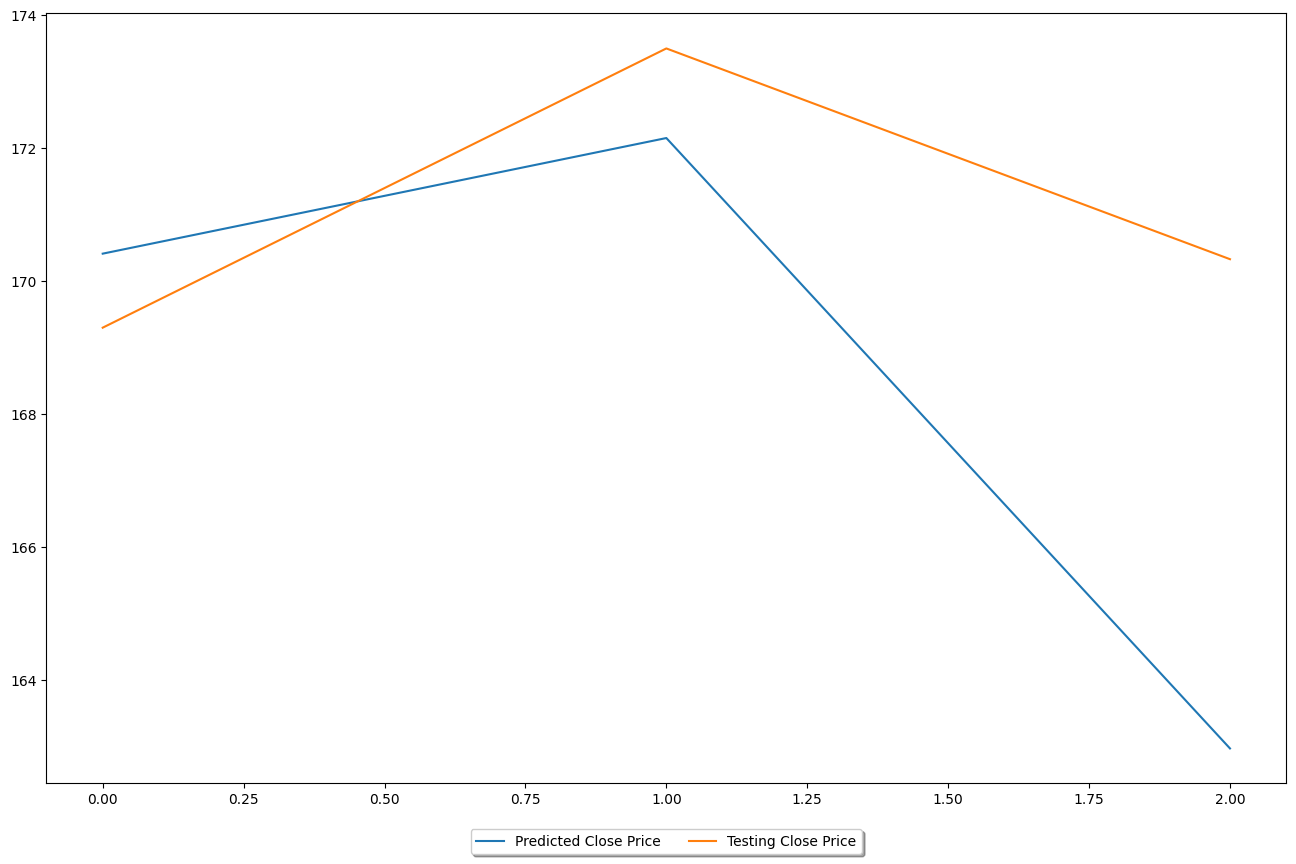

In [37]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()